**Requirements:**
* Trained models
* RDKit: 
     * fine-tuned:      `'c824e42f7ce751cf9a8ed26f0d9e0af7'` 
     * non-pretrained: `'59bdaefb1c1adfaf2976e3fdf62afa21'`

Here everything is in setting 1 (identical gene sets) 

**Outputs:**
* **Figure 2 for RDKit** 
* Figure 5 with DEGs for RDKit
* Supplement Figures 10 & 11 for RDKit
___
# Imports

In [1]:
import matplotlib
import umap.plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

from utils import load_config, load_dataset, load_smiles, load_model, compute_drug_embeddings, compute_pred, compute_pred_ctrl
from chemCPA.data import load_dataset_splits

from chemCPA.paths import FIGURE_DIR, ROOT

2024-05-10 18:42:35.854169: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 18:42:47.096629: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-10 18:42:47.097061: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-05-10 18:42:47.097080: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
BLACK = False 

if BLACK: 
    plt.style.use('dark_background')
else: 
    matplotlib.style.use("fivethirtyeight")
    matplotlib.style.use("seaborn-talk")
    matplotlib.pyplot.rcParams['savefig.facecolor'] = 'white'
    sns.set_style("whitegrid")

matplotlib.rcParams['font.family'] = "monospace"
matplotlib.rcParams['figure.dpi'] = 300
sns.set_context("poster")

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load model configs and dataset
* Define `seml_collection` and `model_hash` to load data and model

In [4]:
# seml_collection = "multi_task"
seml_collection = "chemCPA_configs"

# # RDKit
model_hash_pretrained = "c824e42f7ce751cf9a8ed26f0d9e0af7" # Fine-tuned
model_hash_scratch = "59bdaefb1c1adfaf2976e3fdf62afa21" # Non-pretrained

## Load config and SMILES

In [6]:
import json 
from tqdm.auto import tqdm
from chemCPA.paths import PROJECT_DIR

def load_config(seml_collection, model_hash):
    file_path = PROJECT_DIR / f"{seml_collection}.json"  # Provide path to json

    with open(file_path) as f:
        file_data = json.load(f)

    for _config in tqdm(file_data):
        if _config["config_hash"] == model_hash:
            # print(config)
            config = _config["config"]
            config["config_hash"] = _config["config_hash"]
    return config

In [7]:
config = load_config(seml_collection, model_hash_pretrained)

config["dataset"]["data_params"]["dataset_path"] = ROOT / config["dataset"]["data_params"]["dataset_path"]

dataset, key_dict = load_dataset(config)
config['dataset']['n_vars'] = dataset.n_vars

  0%|          | 0/12 [00:00<?, ?it/s]

In [8]:
canon_smiles_unique_sorted, smiles_to_pathway_map, smiles_to_drug_map = load_smiles(config, dataset, key_dict, True)

Get list of drugs that are ood in `ood_drugs`

In [9]:
ood_drugs = dataset.obs.condition[dataset.obs[config["dataset"]["data_params"]["split_key"]].isin(['ood'])].unique().to_list()

In [10]:
ood_drugs

['Quisinostat',
 'Hesperadin',
 'Flavopiridol',
 'Belinostat',
 'Alvespimycin',
 'TAK-901',
 'Dacinostat',
 'Tanespimycin',
 'Givinostat']

## Load dataset splits

In [11]:
config['dataset']['data_params']

{'covariate_keys': 'cell_type',
 'dataset_path': PosixPath('/nfs/staff-ssd/hetzell/code/chemCPA_v2/project_folder/datasets/sciplex_complete_middle_subset_lincs_genes.h5ad'),
 'degs_key': 'lincs_DEGs',
 'dose_key': 'dose',
 'pert_category': 'cov_drug_dose_name',
 'perturbation_key': 'condition',
 'smiles_key': 'SMILES',
 'split_key': 'split_ood_multi_task',
 'use_drugs_idx': True}

In [12]:
data_params = config['dataset']['data_params']
datasets = load_dataset_splits(**data_params, return_dataset=False)

___
# Run models 
## Baseline model

In [13]:
dosages = [1e1,1e2,1e3,1e4]
cell_lines = ["A549", "K562", "MCF7"]
use_DEGs = True

In [14]:
drug_r2_baseline_degs, _ = compute_pred_ctrl(dataset=datasets['ood'],
                                        dataset_ctrl=datasets['test_control'],
                                        dosages=dosages,
                                        cell_lines=cell_lines,
                                        use_DEGs=True,
                                        verbose=False,
                                       )

drug_r2_baseline_all, _ = compute_pred_ctrl(dataset=datasets['ood'],
                                        dataset_ctrl=datasets['test_control'],
                                        dosages=dosages,
                                        cell_lines=cell_lines,
                                        use_DEGs=False,
                                        verbose=False,
                                       )

['A549', 'K562', 'MCF7']


0it [00:00, ?it/s]

['A549', 'K562', 'MCF7']


0it [00:00, ?it/s]

## Pretrained model

In [15]:
ood_drugs

['Quisinostat',
 'Hesperadin',
 'Flavopiridol',
 'Belinostat',
 'Alvespimycin',
 'TAK-901',
 'Dacinostat',
 'Tanespimycin',
 'Givinostat']

In [16]:
config = load_config(seml_collection, model_hash_pretrained)

config['dataset']['n_vars'] = dataset.n_vars
config["model"]["embedding"]["directory"] = ROOT / config["model"]["embedding"]["directory"]

model_pretrained, embedding_pretrained = load_model(config, canon_smiles_unique_sorted)

  0%|          | 0/12 [00:00<?, ?it/s]

In [17]:
drug_r2_pretrained_degs, _ = compute_pred(model_pretrained, 
                                     datasets['ood'], 
                                     genes_control=datasets['test_control'].genes, 
                                     dosages=dosages,
                                     cell_lines=cell_lines,
                                     use_DEGs=True,
                                     verbose=False,
                                    )

drug_r2_pretrained_all, pred = compute_pred(model_pretrained, 
                                     datasets['ood'], 
                                     genes_control=datasets['test_control'].genes, 
                                     dosages=dosages,
                                     cell_lines=cell_lines,
                                     use_DEGs=False,
                                     verbose=False,
                                    )

['A549', 'K562', 'MCF7']


0it [00:00, ?it/s]

['A549', 'K562', 'MCF7']


0it [00:00, ?it/s]

In [18]:
predictions = []
targets = []
cl_p = []
cl_t = []
d_p = []
d_t = []
for key, vals in pred.items(): 
    cl, drug, _ = key.split("_")
    if '1.0' in key:
        print(key)
        control = vals[0]
        predictions.append(vals[1])
        targets.append(vals[2])
        cl_p.extend(vals[1].shape[0] * [cl])
        cl_t.extend(vals[2].shape[0] * [cl])
        d_p.extend(vals[1].shape[0] * [drug])
        d_t.extend(vals[2].shape[0] * [drug])

A549_Alvespimycin_1.0
A549_Belinostat_1.0
A549_Dacinostat_1.0
A549_Flavopiridol_1.0
A549_Givinostat_1.0
A549_Hesperadin_1.0
A549_Quisinostat_1.0
A549_TAK-901_1.0
A549_Tanespimycin_1.0
K562_Alvespimycin_1.0
K562_Belinostat_1.0
K562_Dacinostat_1.0
K562_Flavopiridol_1.0
K562_Givinostat_1.0
K562_Hesperadin_1.0
K562_Quisinostat_1.0
K562_TAK-901_1.0
K562_Tanespimycin_1.0
MCF7_Alvespimycin_1.0
MCF7_Belinostat_1.0
MCF7_Dacinostat_1.0
MCF7_Flavopiridol_1.0
MCF7_Givinostat_1.0
MCF7_Hesperadin_1.0
MCF7_Quisinostat_1.0
MCF7_TAK-901_1.0
MCF7_Tanespimycin_1.0


In [24]:
import anndata as ad

adata_c = ad.AnnData(control)
adata_p = ad.AnnData(np.concatenate(predictions, axis=0))
adata_t = ad.AnnData(np.concatenate(targets, axis=0))

adata_c.obs['condition'] = 'control'
adata_c.obs['cell_line'] = 'control'
adata_c.obs['perturbation'] = 'control'
adata_p.obs['condition'] = 'prediction'
adata_p.obs['cell_line'] = cl_p
adata_p.obs['perturbation'] = d_p
adata_t.obs['condition'] = 'target'
adata_t.obs['cell_line'] = cl_t
adata_t.obs['perturbation'] = d_t

adata = ad.concat([adata_c,adata_p,adata_t])

import scanpy as sc

sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/nfs/staff-hdd/hetzell/miniconda3/envs/chemical_CPA/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [25]:
adata.obs

,condition,cell_line,perturbation
0,control,control,control
1,control,control,control
2,control,control,control
3,control,control,control
4,control,control,control
...,...,...,...
3288,target,MCF7,Tanespimycin
3289,target,MCF7,Tanespimycin
3290,target,MCF7,Tanespimycin
3291,target,MCF7,Tanespimycin


/nfs/staff-hdd/hetzell/miniconda3/envs/chemical_CPA/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/nfs/staff-hdd/hetzell/miniconda3/envs/chemical_CPA/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


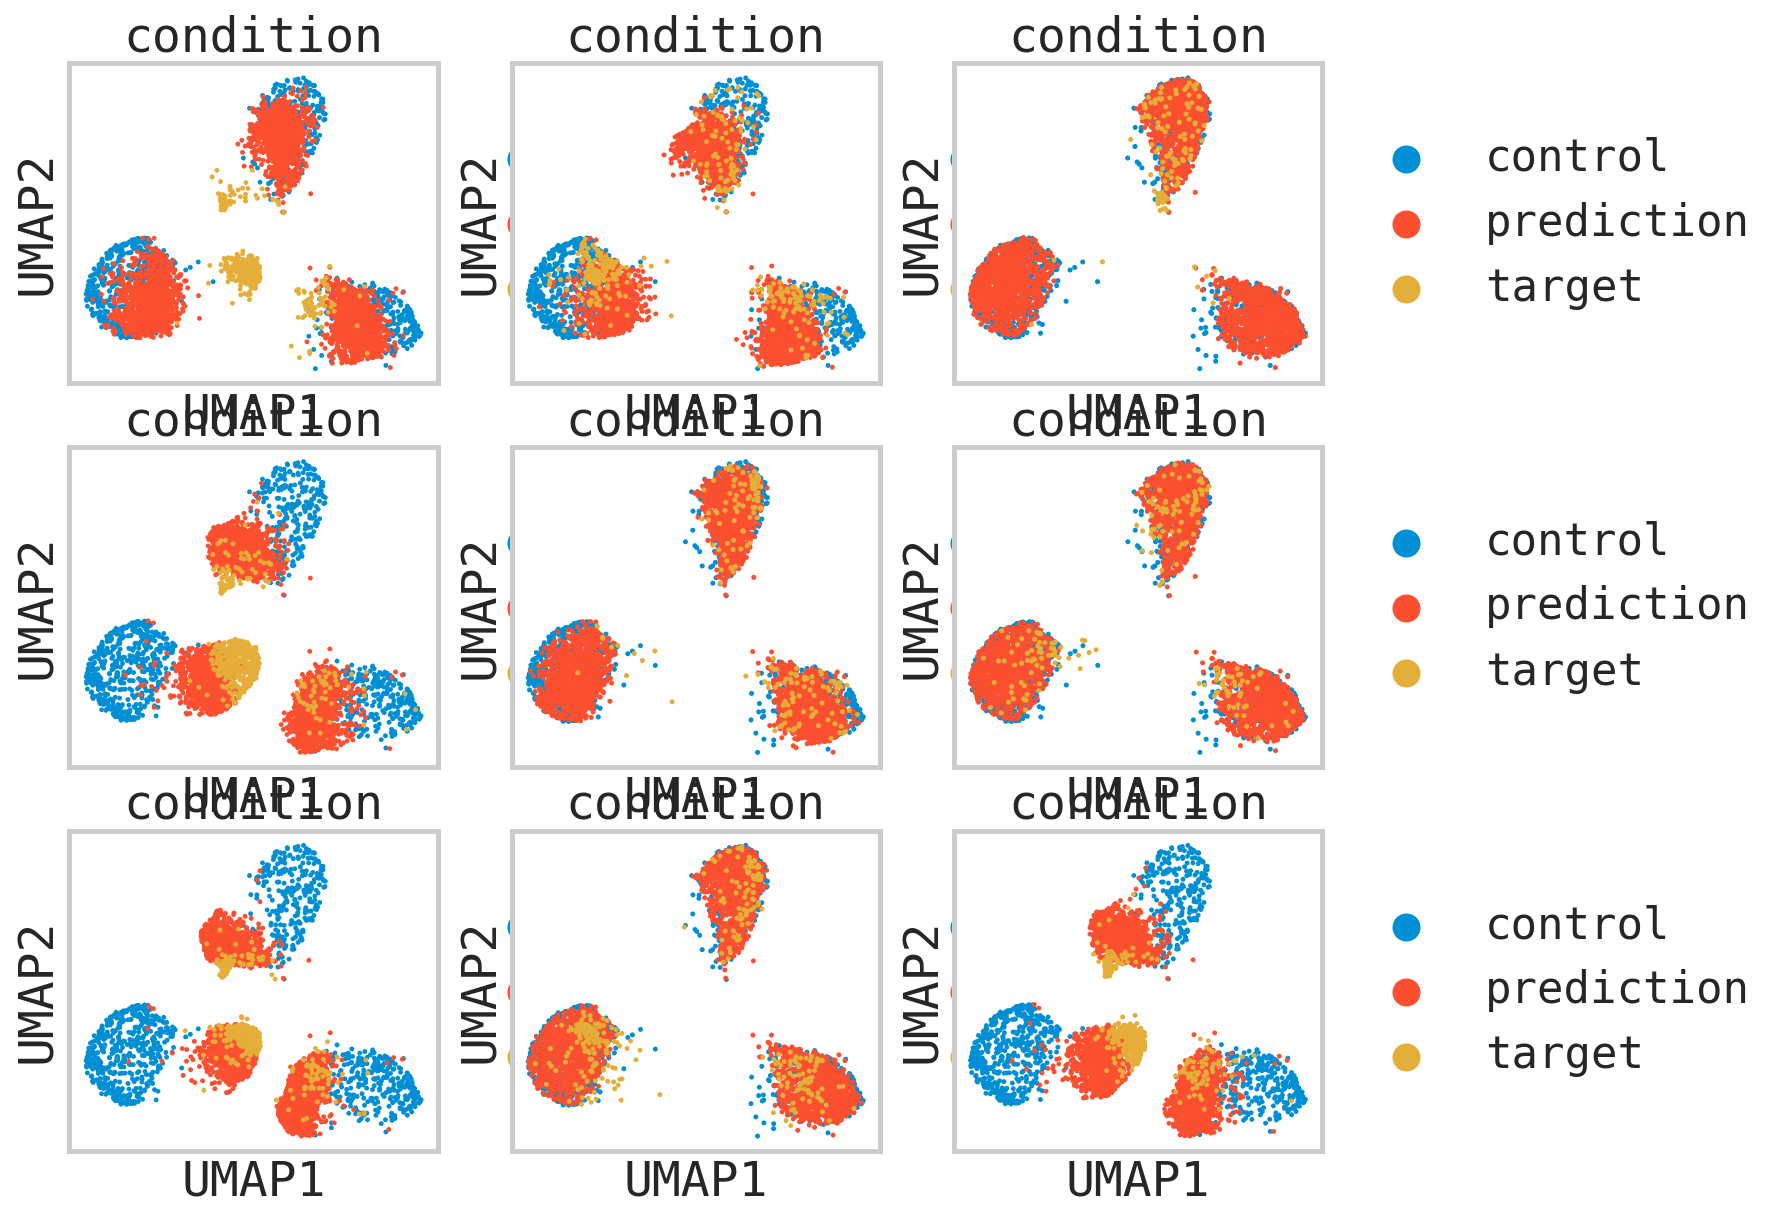

In [ ]:
# cl = "MCF7"
# pert = "Tanespimycin"
# cond = (adata.obs["condition"] == "control") + ((adata.obs["cell_line"] == cl) * (adata.obs["perturbation"] == pert))
fig, ax = plt.subplots(3, 3, figsize=(10,10))
for i, pert in enumerate(ood_drugs):
    axis = ax[i//3, i%3]
    cond = (adata.obs["condition"] == "control") + (adata.obs["perturbation"] == pert)
    sc.pl.umap(adata[cond], color="condition", ax=axis, show=False)
    axis.set_title(f"{pert}")
plt.tight_layout()

## Non-pretrained model

In [38]:
config = load_config(seml_collection, model_hash_scratch)

config['dataset']['n_vars'] = dataset.n_vars
config["model"]["embedding"]["directory"] = ROOT / config["model"]["embedding"]["directory"]

model_scratch, embedding_scratch = load_model(config, canon_smiles_unique_sorted)

  0%|          | 0/12 [00:00<?, ?it/s]

In [39]:
drug_r2_scratch_degs, _ = compute_pred(model_scratch,
                                  datasets['ood'],
                                  genes_control=datasets['test_control'].genes, 
                                  dosages=dosages,
                                  cell_lines=cell_lines,
                                  use_DEGs=True,
                                  verbose=False,
                                 ) # non-pretrained

drug_r2_scratch_all, _ = compute_pred(model_scratch,
                                  datasets['ood'],
                                  genes_control=datasets['test_control'].genes, 
                                  dosages=dosages,
                                  cell_lines=cell_lines,
                                  use_DEGs=False,
                                  verbose=False,
                                 ) # non-pretrained

['A549', 'K562', 'MCF7']


0it [00:00, ?it/s]

['A549', 'K562', 'MCF7']


0it [00:00, ?it/s]

# Combine results and create dataframe

In [40]:
def create_df(drug_r2_baseline, drug_r2_pretrained, drug_r2_scratch):
    df_baseline = pd.DataFrame.from_dict(drug_r2_baseline, orient='index', columns=['r2_de'])
    df_baseline['type'] = 'baseline'
    df_pretrained = pd.DataFrame.from_dict(drug_r2_pretrained, orient='index', columns=['r2_de'])
    df_pretrained['type'] = 'pretrained'
    df_scratch = pd.DataFrame.from_dict(drug_r2_scratch, orient='index', columns=['r2_de'])
    df_scratch['type'] = 'non-pretrained'

    df = pd.concat([df_pretrained, df_scratch, df_baseline])

    df['r2_de'] = df['r2_de'].apply(lambda x: max(x,0))
    df['cell_line'] = pd.Series(df.index.values).apply(lambda x: x.split('_')[0]).values
    df['drug'] = pd.Series(df.index.values).apply(lambda x: x.split('_')[1]).values
    df['dose'] = pd.Series(df.index.values).apply(lambda x: x.split('_')[2]).values
    df['dose'] = df['dose'].astype(float)

    df['combination'] = df.index.values
    assert (df[df.type=='pretrained'].combination == df[df.type=='non-pretrained'].combination).all()

    delta = (df[df.type=='pretrained'].r2_de - df[df.type=='non-pretrained'].r2_de).values 
    df['delta'] = list(delta) + list(-delta) + [0]*len(delta)

    df = df.reset_index()
    return df

In [41]:
df_degs = create_df(drug_r2_baseline_degs, drug_r2_pretrained_degs, drug_r2_scratch_degs)
df_all = create_df(drug_r2_baseline_all, drug_r2_pretrained_all, drug_r2_scratch_all)

# Plot Figure 2 with RDKit

In [42]:
SAVEFIG = False

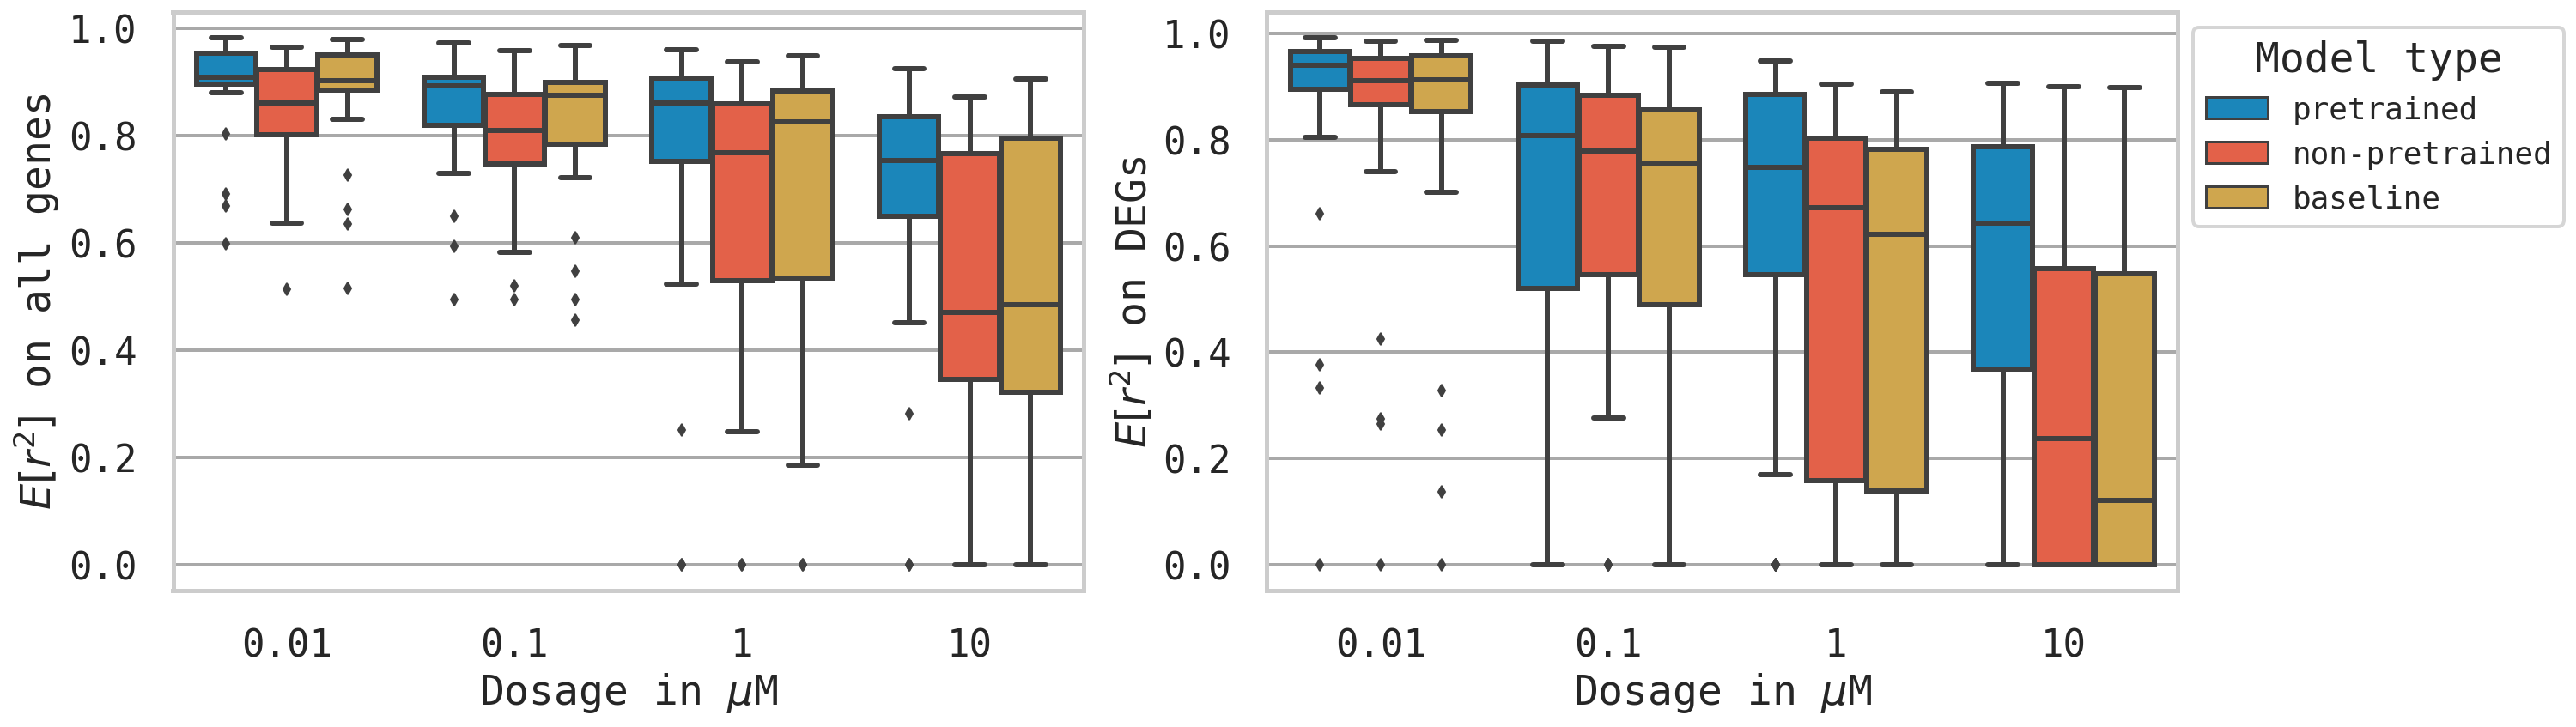

In [43]:
fig, ax = plt.subplots(1,2,figsize=(21, 6))

PROPS = {
    'boxprops':{'edgecolor':'white'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'white'},
    'capprops':{'color':'white'}, 
    'flierprops': {'markerfacecolor': 'lightgrey', "markeredgecolor": "lightgrey"}
}

if BLACK: 
    sns.boxplot(data=df_all, x='dose', y='r2_de', hue='type', whis=1.5, ax=ax[0], palette='tab10', **PROPS) # [(df.r2_de > 0) & (df.delta != 0)]
    sns.boxplot(data=df_degs, x='dose', y='r2_de', hue='type', whis=1.5, ax=ax[1], palette='tab10', **PROPS) # [(df.r2_de > 0) & (df.delta != 0)]
else:
    sns.boxplot(data=df_all, x='dose', y='r2_de', hue='type', whis=1.5, ax=ax[0])
    sns.boxplot(data=df_degs, x='dose', y='r2_de', hue='type', whis=1.5, ax=ax[1])

for j,axis in enumerate(ax):
    x_labels = axis.get_xticklabels()
    dose_labels = ['0.01', "0.1", '1', '10']
    [label.set_text(dose_labels[i]) for i,label in enumerate(x_labels)]
    axis.set_xticklabels(x_labels)
    axis.set_ylabel("$E[r^2]$ on DEGs") if j==1 else None
    axis.set_ylabel("$E[r^2]$ on all genes") if j==0 else None
    axis.set_xlabel("Dosage in $\mu$M") 
    axis.grid('.', color='darkgrey', axis='y')

ax[0].legend().remove()
ax[1].legend(title='Model type', fontsize=18, title_fontsize=24, loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()

if SAVEFIG:
    if BLACK:
        plt.savefig(FIGURE_DIR/'RDKit_shared_gene_set_black.pdf', format='pdf') # BLACK:
    else:
        plt.savefig(FIGURE_DIR/'RDKit_shared_gene_set.pdf', format='pdf') # WHITE


________

# Additional: Supplement Figure 10/11 and Figure 5

In [ ]:
ood_drugs

## Supplement Figure 11 for RDKit
**Parameters**
* DEGs
* Shared genes

In [16]:
df = df_degs.copy()
df.dose = df.dose*10

rows, cols = 3,3
fig, ax = plt.subplots(rows, cols, figsize=(8*cols, 4.5*rows))


for i, drug in enumerate(ood_drugs):
    axis = ax[i//cols, i%cols]
    sns.lineplot(x="dose", y="r2_de", data=df[(df.drug==drug)], hue="type", ax=axis, palette='tab10' if BLACK else None) # & (df.type!="baseline") & (df.cell_line ==cell_line)
    axis.set_title(drug)
#     ax[i].set()
    axis.set_ylim([0,1])
    axis.legend().remove()
    axis.set_ylabel("$E[r^2]$ on DEGs") 
    axis.set_ylabel("$E[r^2]$ on DEGs") 
    axis.set_xlabel("Dosage in $\mu$M") 
    axis.set_xscale("log")

ax[0,2].legend(title='Model type', fontsize=18, title_fontsize=24, loc="lower left", bbox_to_anchor=(1, 0.2))

plt.tight_layout()


if SAVEFIG:
    if BLACK:
        plt.savefig(FIGURE_DIR/'all_drug_examples_rdkit_shared_degs_black.png', format='png')
    else:
        plt.savefig(FIGURE_DIR/'all_drug_examples_rdkit_shared_degs.png', format='png')


NameError: name 'df_degs' is not defined

## Figure 5 for RDKit (DEGs)

In [ ]:
df = df_degs.copy()
df.dose = df.dose*10

STACKED = True

if STACKED:
    # Portrait
    fig, ax = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
else:
    # Landscape
    fig, ax = plt.subplots(1, 2, figsize=(16, 5), sharey=True)


for i, drug in enumerate(["Dacinostat", "Hesperadin"]):
    sns.lineplot(x="dose", y="r2_de", data=df[(df.drug==drug)], hue="type", ax=ax[i], palette='tab10' if BLACK else None) # & (df.type!="baseline") & (df.cell_line ==cell_line)
    ax[i].set_title(drug)
#     ax[i].set()
    ax[i].set_ylim([0,1])
    ax[i].legend(title='Model type', fontsize=18, title_fontsize=24, loc="lower left") #, bbox_to_anchor=(1, 1)
    ax[i].grid('.', color='darkgrey')

ax[0].set_ylabel("$E[r^2]$ on DEGs") 
ax[1].set_ylabel("$E[r^2]$ on DEGs") 
ax[1].set_xlabel("Dosage in $\mu$M") 
ax[0].set_xlabel("Dosage in $\mu$M") 
ax[0].legend().remove()
ax[0].set_xscale("log")
ax[1].set_xscale("log")
plt.tight_layout()

if SAVEFIG:
    if BLACK:
        plt.savefig(FIGURE_DIR/'drug_examples_rdkit_shared_degs_black.png', format='png') # BLACK
    else:
        plt.savefig(FIGURE_DIR/'drug_examples_rdkit_shared_degs.png', format='png')

## Supplement Figure 10 for RDKit

**Parameters**
* All genes
* Shared genes

In [ ]:
df = df_all.copy()
df.dose = df.dose*10

rows, cols = 3,3
fig, ax = plt.subplots(rows, cols, figsize=(8*cols, 4.5*rows))


for i, drug in enumerate(ood_drugs):
    axis = ax[i//cols, i%cols]
    sns.lineplot(x="dose", y="r2_de", data=df[(df.drug==drug)], hue="type", ax=axis, palette='tab10' if BLACK else None) # & (df.type!="baseline") & (df.cell_line ==cell_line)
    axis.set_title(drug)
#     ax[i].set()
    axis.set_ylim([0,1])
    axis.legend().remove()
    axis.set_ylabel("$E[r^2]$ on all genes") 
    axis.set_ylabel("$E[r^2]$ on all genes") 
    axis.set_xlabel("Dosage in $\mu$M") 
    axis.set_xscale("log")

ax[0,2].legend(title='Model type', fontsize=18, title_fontsize=24, loc="lower left", bbox_to_anchor=(1, 0.2))

plt.tight_layout()


if SAVEFIG:
    if BLACK:
        plt.savefig(FIGURE_DIR/'all_drug_examples_rdkit_shared_all_genes_black.png', format='png')
    else:
        plt.savefig(FIGURE_DIR/'all_drug_examples_rdkit_shared_all_genes.png', format='png')


## Figure 5 for RDKit (All genes)

In [ ]:
df = df_all.copy()
df.dose = df.dose*10


STACKED = False

if STACKED:
    # Portrait
    fig, ax = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
else:
    # Landscape
    fig, ax = plt.subplots(1, 2, figsize=(16, 5), sharey=True)


for i, drug in enumerate(["Dacinostat", "Hesperadin"]):
    sns.lineplot(x="dose", y="r2_de", data=df[(df.drug==drug)], hue="type", ax=ax[i], palette='tab10' if BLACK else None) # & (df.type!="baseline") & (df.cell_line ==cell_line)
    ax[i].set_title(drug)
#     ax[i].set()
    ax[i].set_ylim([0,1])
    ax[i].legend(title='Model type', fontsize=18, title_fontsize=24, loc="lower left") #, bbox_to_anchor=(1, 1)
    ax[i].grid('.', color='darkgrey')

ax[0].set_ylabel("$E[r^2]$ on all genes") 
ax[1].set_ylabel("$E[r^2]$ on all genes") 
ax[1].set_xlabel("Dosage in $\mu$M") 
ax[0].set_xlabel("Dosage in $\mu$M") 
ax[0].legend().remove()
ax[0].set_xscale("log")
ax[1].set_xscale("log")
plt.tight_layout()

if SAVEFIG:
    if BLACK:
        plt.savefig(FIGURE_DIR/'drug_examples_rdkit_shared_all_genes_black.png', format='png') # BLACK
    else:
        plt.savefig(FIGURE_DIR/'drug_examples_rdkit_shared_all_genes.png', format='png')

___